<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [25]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Se utiliza un dataset con diferentes textos (corpus Gutemberg), seleccionando finalmente Tiny Shakespeare.

In [26]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [27]:
import requests

# URL directa al corpus de Tiny Shakespeare en GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# Descargar el contenido del corpus
try:
    response = requests.get(url)
    response.raise_for_status()  # Lanza un error para códigos de estado HTTP incorrectos (4xx o 5xx)
    article_text = response.text
    article_text = article_text.lower()
    print(f"Corpus de Tiny Shakespeare cargado. Longitud: {len(article_text)} caracteres.")
except requests.exceptions.RequestException as e:
    print(f"Error al descargar el corpus: {e}")
    article_text = "" # Asegura que article_text esté vacío en caso de error

Corpus de Tiny Shakespeare cargado. Longitud: 1115394 caracteres.


In [28]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

"first citizen:\nbefore we proceed any further, hear me speak.\n\nall:\nspeak, speak.\n\nfirst citizen:\nyou are all resolved rather to die than to famish?\n\nall:\nresolved. resolved.\n\nfirst citizen:\nfirst, you know caius marcius is chief enemy to the people.\n\nall:\nwe know't, we know't.\n\nfirst citizen:\nlet us kill him, and we'll have corn at our own price.\nis't a verdict?\n\nall:\nno more talking on't; let it be done: away, away!\n\nsecond citizen:\none word, good citizens.\n\nfirst citizen:\nwe are accounted poor citizens, the patricians good.\nwhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them let us revenge this with\nour pikes, ere we become rakes: for the gods know i\nspeak this in hunger 

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [29]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [30]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [31]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [32]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

39

In [33]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [34]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [35]:
tokenized_text[:1000]

[23,
 15,
 24,
 37,
 0,
 4,
 32,
 15,
 0,
 15,
 20,
 34,
 36,
 27,
 28,
 19,
 34,
 23,
 10,
 24,
 34,
 4,
 7,
 34,
 4,
 25,
 24,
 10,
 32,
 34,
 34,
 30,
 4,
 16,
 36,
 26,
 4,
 23,
 38,
 24,
 0,
 33,
 34,
 24,
 11,
 4,
 33,
 34,
 16,
 24,
 4,
 35,
 34,
 4,
 37,
 25,
 34,
 16,
 12,
 3,
 28,
 28,
 16,
 21,
 21,
 27,
 28,
 37,
 25,
 34,
 16,
 12,
 11,
 4,
 37,
 25,
 34,
 16,
 12,
 3,
 28,
 28,
 23,
 15,
 24,
 37,
 0,
 4,
 32,
 15,
 0,
 15,
 20,
 34,
 36,
 27,
 28,
 26,
 10,
 38,
 4,
 16,
 24,
 34,
 4,
 16,
 21,
 21,
 4,
 24,
 34,
 37,
 10,
 21,
 13,
 34,
 30,
 4,
 24,
 16,
 0,
 33,
 34,
 24,
 4,
 0,
 10,
 4,
 30,
 15,
 34,
 4,
 0,
 33,
 16,
 36,
 4,
 0,
 10,
 4,
 23,
 16,
 35,
 15,
 37,
 33,
 17,
 28,
 28,
 16,
 21,
 21,
 27,
 28,
 24,
 34,
 37,
 10,
 21,
 13,
 34,
 30,
 3,
 4,
 24,
 34,
 37,
 10,
 21,
 13,
 34,
 30,
 3,
 28,
 28,
 23,
 15,
 24,
 37,
 0,
 4,
 32,
 15,
 0,
 15,
 20,
 34,
 36,
 27,
 28,
 23,
 15,
 24,
 37,
 0,
 11,
 4,
 26,
 10,
 38,
 4,
 12,
 36,
 10,
 7,
 4,
 32,
 16,
 1

### Organizando y estructurando el dataset

In [36]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [37]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [38]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [39]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [40]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [41]:
X.shape

(1003694, 100)

In [42]:
X[0,:10]

array([23, 15, 24, 37,  0,  4, 32, 15,  0, 15])

In [43]:
y[0,:10]

array([15, 24, 37,  0,  4, 32, 15,  0, 15, 20])

In [44]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [45]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GRU
from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None,1)))
model.add(GRU(64, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data_raw, history_ppl, patience=5, sample_size=256, batch_size_pred=128):
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.model_saved_path = "my_model.keras"
        self.batch_size_pred = batch_size_pred

        if len(val_data_raw) > sample_size:
            val_data_raw = np.array(val_data_raw, dtype=object)
            indices = np.random.choice(len(val_data_raw), sample_size, replace=False)
            val_data = val_data_raw[indices]
        else:
            val_data = val_data_raw

        self.target = []
        self.padded_inputs = []
        self.info = []
        current_idx = 0

        for seq in val_data:
            len_seq = len(seq)
            if len_seq > 1:
                subseq_inputs = [seq[:i] for i in range(1, len_seq)]
                self.target.extend([seq[i] for i in range(1, len_seq)])
                padded_subseq = pad_sequences(subseq_inputs, maxlen=max_context_size, padding='pre')
                self.padded_inputs.append(padded_subseq)
                self.info.append((current_idx, current_idx + len(padded_subseq)))
                current_idx += len(padded_subseq)

        if self.padded_inputs:
            self.padded_inputs = np.vstack(self.padded_inputs)
        else:
            self.padded_inputs = np.array([])
            print("Advertencia: No se generaron datos para el cálculo de perplejidad.")

        self.target = np.array(self.target)

    def on_epoch_end(self, epoch, logs=None):
        if self.padded_inputs.size == 0:
            print("\n No hay datos de validación para calcular la perplejidad en esta época. \n")
            return

        print("\n Iniciando predicción de la epoca... \n")
        predictions_all = self.model.predict(self.padded_inputs[:4000], verbose=0)

        target_indices = self.target[:len(predictions_all)].astype(int)
        assert len(predictions_all) == len(target_indices), "Dimensiones no coinciden"

        predicted_probabilities = predictions_all[np.arange(len(predictions_all)), -1, target_indices]
        predicted_probabilities[predicted_probabilities == 0] = np.finfo(float).eps
        log_probs = np.log(predicted_probabilities)

        scores = []
        for start, end in self.info:
            sum_log_probs_seq = np.sum(log_probs[start:end])
            len_targets_seq = end - start
            if len_targets_seq > 0:
                scores.append(np.exp(-sum_log_probs_seq / len_targets_seq))
            else:
                scores.append(0.0)

        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n Perplejidad promedio: {current_score:.4f} \n')

        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(self.model_saved_path)
            print(f"Modelo guardado: Nueva mejor perplejidad: {self.min_score:.4f}")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            print(f"Perplejidad no mejoró. Paciencia: {self.patience_counter}/{self.patience}")
            if self.patience_counter >= self.patience:
                print("Deteniendo el entrenamiento (Early Stopping)...")
                self.model.stop_training = True


### Entrenamiento

In [48]:
history_ppl = []
callback = PplCallback(tokenized_sentences_val, history_ppl, sample_size=256, batch_size_pred=1048)
hist = model.fit(X, y, epochs=30, callbacks=[callback], batch_size=1048)

Epoch 1/30
956/958 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2584 - loss: 2.6446
 Iniciando predicción de la epoca... 


 Perplejidad promedio: 1.1295 

Modelo guardado: Nueva mejor perplejidad: 1.1295
958/958 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.2587 - loss: 2.6436
Epoch 2/30
956/958 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4141 - loss: 1.9534
 Iniciando predicción de la epoca... 


 Perplejidad promedio: 1.1082 

Modelo guardado: Nueva mejor perplejidad: 1.1082
958/958 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.4141 - loss: 1.9532
Epoch 3/30
956/958 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4696 - loss: 1.7749
 Iniciando predicción de la epoca... 


 Perplejidad promedio: 1.0993 

Modelo guardado: Nueva mejor perplejidad: 1.0993
958/958 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.4696 - loss: 1.7748
Epoch 4/30
957/958 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4945 - loss: 1.6807
 Iniciando predicción de la epoca... 


 Perplejidad prome

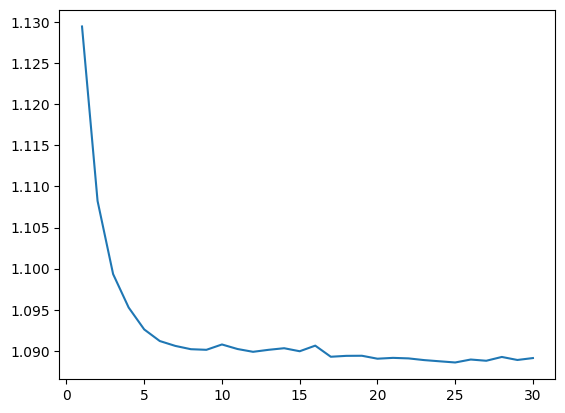

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [50]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [51]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [52]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c73860e4eddf2af18e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c73860e4eddf2af18e.gradio.live


### Generación de secuencias

In [53]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [54]:
input_text='once uppon'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'once upponious country that the father t'

###  Beam search y muestreo aleatorio

In [55]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [56]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=0.8,mode='sto'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [57]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="once uppon")

In [58]:
salidas[0]

array([10, 36, 32, 34,  4, 38, 25, 25, 10, 36, 15, 10, 38, 37,  4, 23, 24,
       15, 34, 36, 30, 37,  4,  7, 15,  0, 33,  4, 35, 26])

In [59]:
# veamos las salidas
decode(salidas[0])

'once upponious friends with my'

# Perplejidad

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

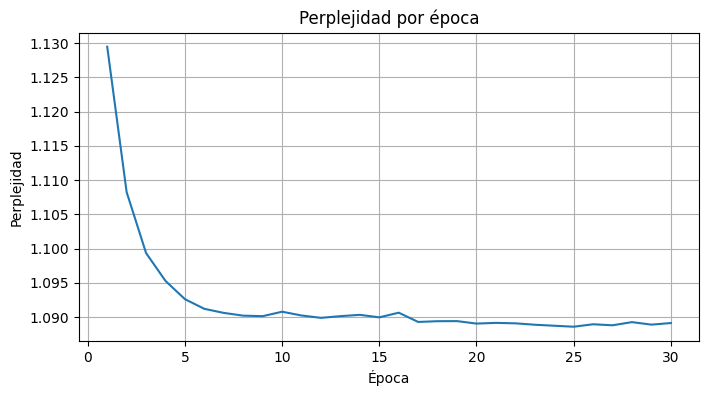

In [61]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.title("Perplejidad por época")
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.grid(True)
plt.show()

# Accuracy

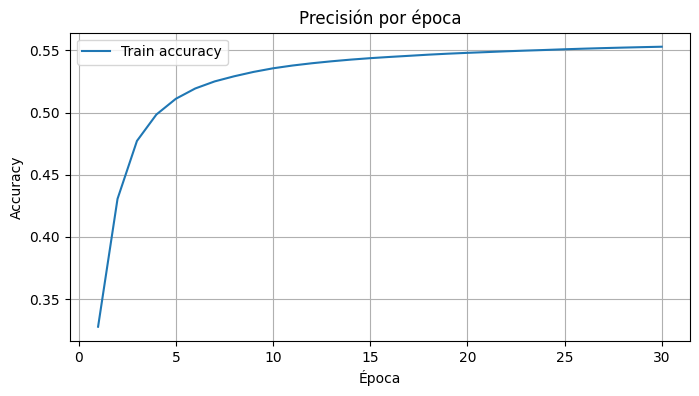

In [62]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(hist.history['accuracy'])+1), y=hist.history['accuracy'], label='Train accuracy')
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## Conclusiones

En los primeros ensayos no se lograba alcanzar con ningún corpus un uso adecuado de la notebook ya que se saturaba la memoria de Colab.

Ante esto, se tomaron distintas medidas para resolverlo.
Primero se redujo el valor del contexto a 40 y se busco un corpus más pequeño, eligiéndose “Tiny Shakespeare”.

Después se redujeron las neuronas a 16 en el modelo LSTM, pero agregándose otra capa densa. Asimismo se bajaron los samples del modelo a 1000, ya que completaban más de 300000 y saturaba el sistema. Si bien en este punto, el sistema completaba el entrenamiento, solo predecía siempre la misma palabra (“the”, “that”).

Posteriormente se subieron el número de neuronas a 32 y se logró una mejora en la perplejidad, accuracy y perdida.

También se cambio el optimizador, pasando de Adam a RMSprop, se subieron los samples a 4000 y el contexto a 100, obteniendo valores de métricas superiores, pero resultados en la predicción bastante insatisfactorios, ya que predecian siempre las mismas dos palabras.

Finalmente se cambia el modelo a GRU, y se lográ un aumento significativo en la velocidad de entrenamiento, así como un incremento en las métricas, por lo que se vuelve a incrementar las épocas, llevandolas a 30, y las neuronas a 64.
De esta manera se logra un resultado final con Perplejidad de 1.0891, accuracy de 0.5527 y perdida de 1.4463.
Se observó también que la perplejidad ya no seguía mejorando y se volvía más inestable, por lo que se interpreta que con el corpus utilizado se llegó al máximo de la capacidad de entrenamiento que nos permitía el entorno de Colab con estos parámetros.
Como resultado, se lograron resultados mucho mejores, con predicciones que conformaban oraciones más completas (aunque a veces con poco sentido en algún punto).
También se menciona que se probó cambiando el criterio de selección de candidatos a Estocástico (“sto”), con una temperatura de 0.8, para lograr algo más de flexibilidad en la selección.

Claramente, GRU nos arroja mejores resultados, verificándose una mejora significativa de tiempos de entrenamiento, y un incremento en las métricas, que finalmente se traduce en un mejor resultado real, por lo menos con nuestro corpus y nuestras limitaciones de entorno.